# Task 1: 3-DOF Oscillator
Sam Greydanus

In [1]:
import torch, time, sys
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-3dof'
sys.path.append(EXPERIMENT_DIR)

from data_3dof import get_dataset, get_field, get_trajectory, dynamics_fn, hamiltonian_fn
from nn_models import MLP
from hnn import HNN
from utils import L2_loss

## Set some notebook constants

In [2]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 30
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 2*3,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 5000,
         'field_type': 'solenoidal',
         'print_every': 50,
         'name': 'mdof',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Inspect the dataset

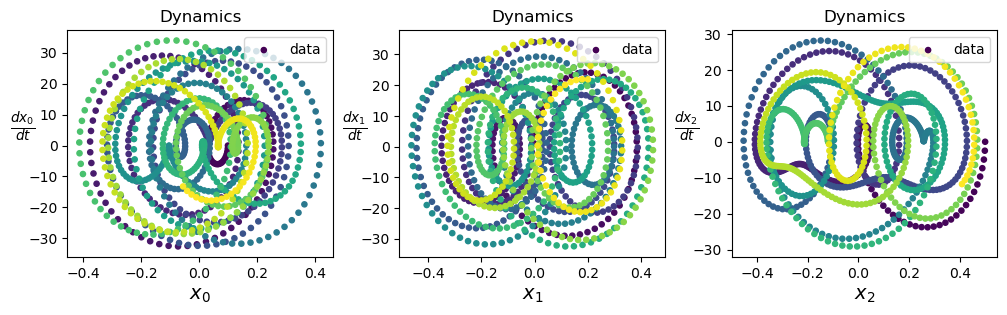

In [3]:
args = ObjectView(get_args())
x1, x2, x3, y1, y2, y3, dx1, dx2, dx3, dy1, dy2, dy3, t = get_trajectory(t_span=[0,1], radius=1, timescale=1000,
                                                                         y0=np.array([0.1, 0, 0.5, 0, 1, 0]))
x = np.stack((x1, x2, x3))
y = np.stack((y1, y2, y3))

# plot config
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3), facecolor='white', dpi=100)
plt.subplots_adjust(wspace=0.25)
for i in range(3):
    ax[i].scatter(x[i], y[i], c=t,s=14, label='data')
    ax[i].set_xlabel("$x_{}$".format(i), fontsize=14)
    ax[i].set_ylabel("$\\frac{dx_{%d}}{dt}$" % i, rotation=0, fontsize=14)
    ax[i].set_title("Dynamics")
    ax[i].legend(loc='upper right')
plt.show()


In [4]:
np.stack((x1, x1)).shape


(2, 1000)

## Construct models

In [5]:
def get_model(args, baseline):
    output_dim = args.input_dim if baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type, baseline=baseline)
    
    model_name = 'baseline' if baseline else 'hnn'
    path = "{}/{}.tar".format(args.save_dir, 'mdof-hnn')
    model.load_state_dict(torch.load(path))
    return model

## Get vector fields

In [6]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']
    
    # run model
    mesh_x = torch.tensor( np_mesh_x, requires_grad=True, dtype=torch.float32)
    mesh_dx = model.time_derivative(mesh_x)
    return mesh_dx.data.numpy()

## Integrate along vector fields

In [7]:
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,6)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

## Run analysis

In [8]:
hnn_model = get_model(args, baseline=False)

# integrate along those fields starting from point (1,0)
t_span = [0,1]
y0 = np.asarray([0.1, 0, 0.5, 0, 1, 0], np.float32)
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}

hnn_ivp = integrate_model(hnn_model, t_span, y0, **kwargs)

In [9]:
hnn_ivp['y'].shape

(6, 1000)

## Plot results

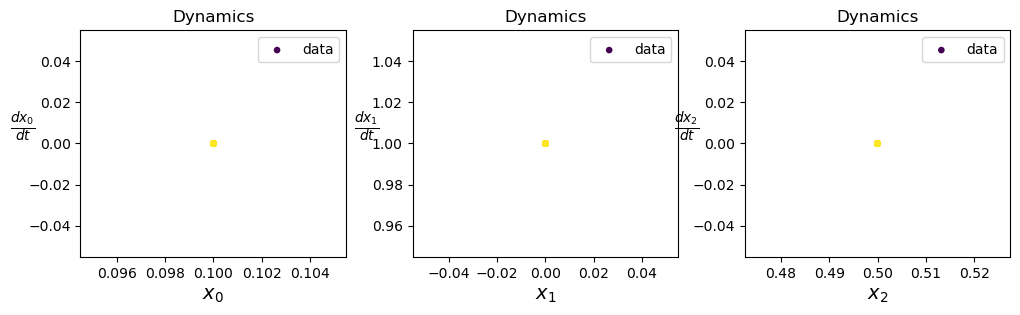

In [10]:
###### PLOT ######
x = hnn_ivp['y'][:3, :]
y = hnn_ivp['y'][3:, :]

# plot config
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3), facecolor='white', dpi=100)
plt.subplots_adjust(wspace=0.25)
for i in range(3):
    ax[i].scatter(x[i], y[i], c=t,s=14, label='data')
    ax[i].set_xlabel("$x_{}$".format(i), fontsize=14)
    ax[i].set_ylabel("$\\frac{dx_{%d}}{dt}$" % i, rotation=0, fontsize=14)
    ax[i].set_title("Dynamics")
    ax[i].legend(loc='upper right')
plt.show()


## Quantitative analysis

* Compare the energies, Hamiltonian

In [11]:
def true_Hamiltonian(state, m=1, k1=5000, k2=5000, k3=5000):
    q1, q2, q3, q_dot1, q_dot2, q_dot3 = state
    T = 0.5 * m * (q_dot1**2 + q_dot2**2 + q_dot3**2)
    V = 0.5 * k1 * q1**2 + 0.5 * k2 * (q2-q1)**2 + 0.5 * k3 * (q3-q2)**2
    return T + V

samples = 25
H_true_ensemble = []
H_hnn_ensemble = []
for i in range(samples):
    print('Sample-{}'.format(i))
    
    y_init = np.random.uniform(0.1,1,size=3)
    t_span = [0,1]
    y0 = np.zeros(6, dtype=np.float32)
    y0[::2] = y_init
    
    x1_, x2_, x3_, y1_, y2_, y3_, _, _, _, _, _, _, _ = get_trajectory(t_span=t_span, radius=1, timescale=1000,
                                                                    y0=y0)
    
    kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}
    hnn_ivp_ = integrate_model(hnn_model, t_span, y0, **kwargs)
    
    H_true = true_Hamiltonian([x1_, x2_, x3_, y1_, y2_, y3_])
    H_hnn = hamiltonian_fn(hnn_ivp_['y'])[0]
    
    H_true_ensemble.append( H_true )
    H_hnn_ensemble.append( H_hnn )

H_true_ensemble = np.array( H_true_ensemble ) 
H_hnn_ensemble = np.array( H_hnn_ensemble )


Sample-0
Sample-1
Sample-2
Sample-3
Sample-4
Sample-5
Sample-6
Sample-7
Sample-8
Sample-9
Sample-10
Sample-11
Sample-12
Sample-13
Sample-14
Sample-15
Sample-16
Sample-17
Sample-18
Sample-19
Sample-20
Sample-21
Sample-22
Sample-23
Sample-24


In [12]:
print(H_true_ensemble.shape, H_hnn_ensemble.shape)

(25, 1000) (25, 1000)


In [13]:
y1_.shape

(1000,)

In [14]:
error_HNN = np.abs(H_hnn_ensemble - H_true_ensemble)/ np.abs(H_true_ensemble)

mean_HNN = np.mean(error_HNN, axis = 0)
std_HNN = np.std(error_HNN, axis = 0)

print(error_HNN.shape)


(25, 1000)


In [15]:
print('L2 error: HNN--', 100*np.mean(error_HNN))

L2 error: HNN-- 45.45241047850488


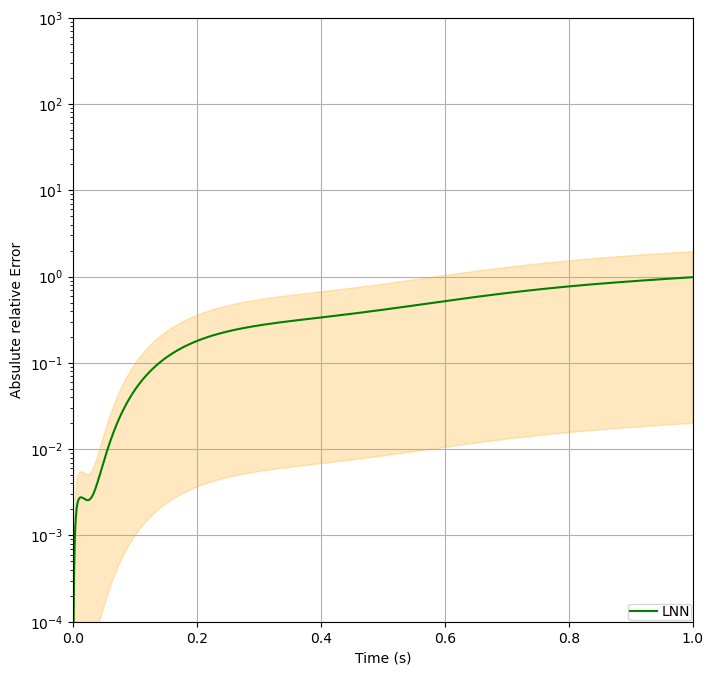

In [20]:
fig4 = plt.figure(figsize=(8,8), dpi=100)
plt.plot( np.linspace(0, 1, 1000), mean_HNN, 'g' , label='LNN' )
plt.fill_between(np.linspace(0, 1, 1000), mean_HNN-((1/np.sqrt(samples))*std_HNN), 
                 mean_HNN+((1/np.sqrt(samples))*std_HNN),
                 color='orange', alpha=0.25)

plt.ylabel('Absulute relative Error')
plt.xlabel('Time (s)')
plt.yscale('log')
plt.ylim([1e-4,1000])
plt.legend(loc=4, labelspacing=0.1, borderaxespad=0.1, handletextpad=0.3, borderpad=0.1)
plt.margins(0)
plt.grid(True)

# fig4.savefig('Error_nonlin_total_energy.pdf', format='pdf', dpi=600, bbox_inches='tight')


In [17]:
from scipy import io as sio

In [18]:
sio.savemat('Results_3dof_HNN.mat', mdict={'H_true_ensemble':H_true_ensemble,
                                                'H_hnn_ensemble':H_hnn_ensemble,
                                                'error_HNN':error_HNN, })
